In [1]:
import os
import random
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoTokenizer
from torchvision import models, transforms
import torchvision.transforms as T
from torchvision.models import ResNet101_Weights
import streamlit as st

In [2]:
# Image transformation parameters
image_input_size = (224, 224)
mean_normalization_vec = [0.485, 0.456, 0.406]
std_normalization_vec = [0.229, 0.224, 0.225]

# Define image transformation pipeline
image_transformation = T.Compose([
    T.Resize(image_input_size),             # Resize image to the target size
    T.ToTensor(),                            # Convert image to a tensor
    T.Normalize(mean=mean_normalization_vec, std=std_normalization_vec)  # Normalize the image
])


In [3]:
def set_cuda():
    """Set device to CUDA if available, else default to CPU."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device in use: {device}")
    return device

def detensorize_image(image_tensor, mean_vector, std_vector, denormalize=True): 
    """
    Denormalize the image tensor to the original pixel range (0-255).
    Args:
        image_tensor (torch.Tensor): The image tensor to be denormalized.
        mean_vector (list): The mean values for each channel.
        std_vector (list): The standard deviation values for each channel.
        denormalize (bool): Whether to apply denormalization.
    Returns:
        numpy.ndarray: The denormalized image as a NumPy array.
    """
    # Reshape mean and std vectors to tensors with appropriate shape
    mean_tensor = torch.tensor(mean_vector).view(3, 1, 1)
    std_tensor = torch.tensor(std_vector).view(3, 1, 1)
    
    if denormalize:
        detensorized_image = (image_tensor * std_tensor) + mean_tensor
    else:
        detensorized_image = image_tensor
    
    detensorized_image = detensorized_image.permute(1, 2, 0)  # Convert image dimensions from (C, H, W) to (H, W, C)
    detensorized_image = detensorized_image.numpy()  # Convert tensor to a NumPy array for visualization
    
    return detensorized_image

def standardize_text(text):
    """Clean and standardize text by removing punctuation and converting to lowercase."""
    text = text.strip()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = text.lower()
    
    return text

def plot_attention(img, caption, attention_vectors, is_streamlit=False):
    """
    Plot attention maps on the image.
    Args:
        img (numpy.ndarray): The input image.
        caption (list): List of caption words.
        attention_vectors (list): List of attention vectors for each caption word.
        is_streamlit (bool): If True, display in Streamlit using st.pyplot.
    """
    temp_image = img
    fig, axes = plt.subplots(len(caption) - 1, 1, figsize=(8, 8 * (len(caption) - 1)))

    assert len(caption) > 1, f"Image has a caption with only {len(caption)} words."

    for l, ax in enumerate(axes):
        temp_att = attention_vectors[l].reshape(7, 7)  # Convert the 49 attention vector to a 7x7 attention map
        att_resized = cv2.resize(temp_att, (temp_image.shape[1], temp_image.shape[0]))  # Resize attention map to image size

        ax.imshow(temp_image)
        ax.imshow(att_resized, cmap='jet', alpha=0.4)  # Heatmap over the original image for attended regions
        ax.set_title(caption[l])
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
    if is_streamlit:
        st.pyplot(fig)  # Display the plot in Streamlit if applicable

def pick_random_image(directory):
    """
    Pick a random image file from the specified directory.
    Args:
        directory (str): Path to the image directory.
    Returns:
        str: A randomly selected image file name.
    """
    files = os.listdir(directory)
    images = [f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    
    assert images, "No images found in the directory."
    random_image = random.choice(images)
    
    return random_image


In [4]:
# Define dataset paths
datapath = "dataset/flickr30k-dataset"
image_path = os.path.join(datapath, "Images")
captions_path = os.path.join(datapath, "captions.txt")  # Captions format in text: "image name, image caption"

# Print the paths
print(f"Image Path: {image_path}")
print(f"Captions Path: {captions_path}")

Image Path: dataset/flickr30k-dataset/Images
Captions Path: dataset/flickr30k-dataset/captions.txt


In [5]:
# Initialize lists to store image names and captions
image_names = []  # List to store image names from "captions.txt"
captions_list = []  # List to store captions corresponding to the images

# Regular expression pattern to match image name and caption pairs in the captions text file
pattern = r'([a-zA-Z0-9]+\.[a-zA-Z]+),\s*(.*)'

# Open and read the captions file
with open(captions_path, 'r') as text:
    for line in text:
        # Use regex to match the image name and caption
        match = re.match(pattern, line.strip())
        
        if match:
            # Extract image name and caption
            img_name = match.group(1)
            img_caption = match.group(2)
            
            # Append image name and standardized caption to respective lists
            image_names.append(img_name)
            captions_list.append(standardize_text(img_caption))  # Corrected function name

# Optionally, print out the first few entries to verify
print(image_names[:4])
print(captions_list[:4])

['1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '1000092795.jpg']
['two young guys with shaggy hair look at their hands while hanging out in the yard ', 'two young  white males are outside near many bushes ', 'two men in green shirts are standing in a yard ', 'a man in a blue shirt standing in a garden ']


In [6]:
# Create the DataFrame from image names and captions lists
im_cap_df = pd.DataFrame({
    "Image_name": image_names,
    "caption": captions_list  # Standardized capitalization for consistency
})

# Display the first few rows of the DataFrame to verify
print(im_cap_df.head())

       Image_name                                            caption
0  1000092795.jpg  two young guys with shaggy hair look at their ...
1  1000092795.jpg  two young  white males are outside near many b...
2  1000092795.jpg    two men in green shirts are standing in a yard 
3  1000092795.jpg        a man in a blue shirt standing in a garden 
4  1000092795.jpg             two friends enjoy time spent together 


In [7]:
# Use the correct column name ('Caption' instead of 'caption')
print(f"Total number of captions: {len(im_cap_df['caption'])}")
print(f"Number of unique image entries in captions file: {im_cap_df['Image_name'].nunique()}")
print(f"Number of images in images directory: {len([img for img in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, img))])}")
print(f"Caption count per image is: {im_cap_df.groupby('Image_name')['caption'].count().unique()}")

Total number of captions: 158915
Number of unique image entries in captions file: 31783
Number of images in images directory: 31783
Caption count per image is: [5]


In [8]:
# Ensure that all image files listed in image_names exist in the specified directory
missing_images = [name for name in image_names if not os.path.exists(os.path.join(image_path, name))]

# Check if there are any missing images
assert not missing_images, f"Cannot find the following images in the directory: {', '.join(missing_images)}"

print("All image entries in captions file match images in the images folder.")

All image entries in captions file match images in the images folder.


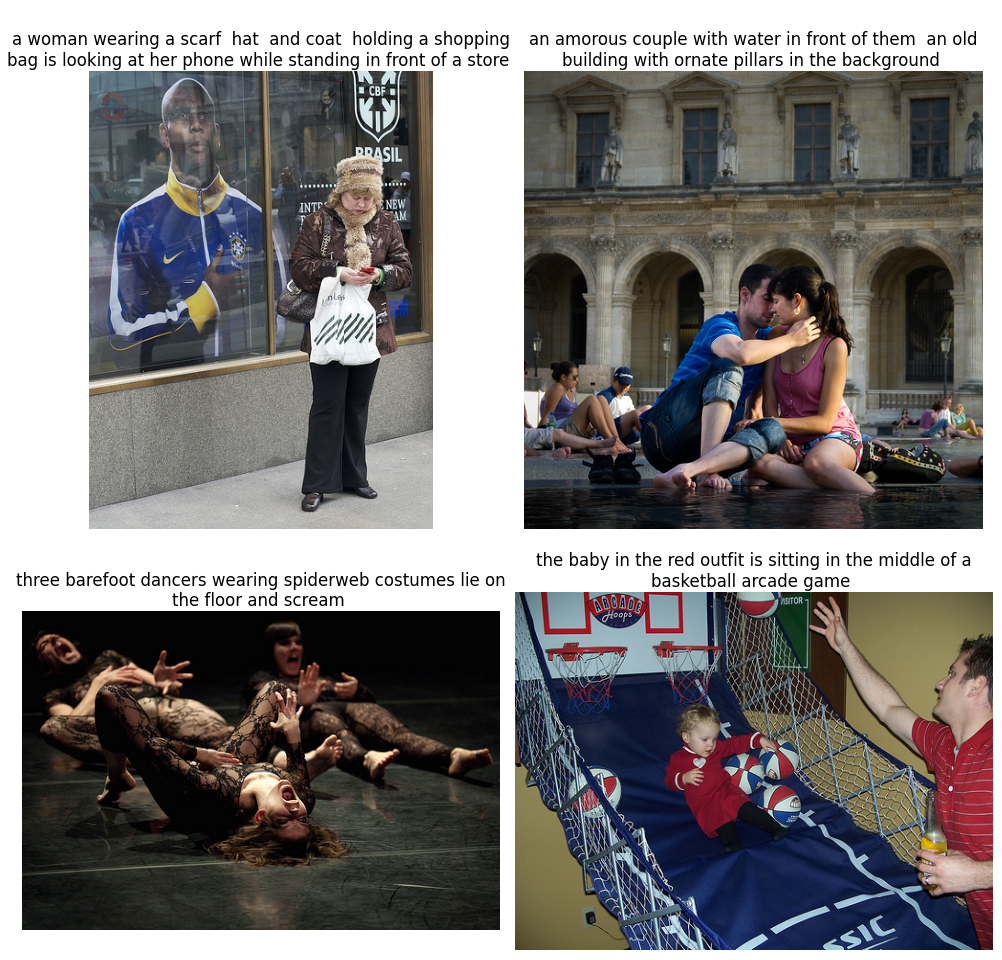

In [9]:
'''displaying some Random images with their corresponding captions'''
# Create a 2x2 grid of images and their corresponding captions
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i in range(4):
    # Pick a random image from the image directory
    image_name = pick_random_image(image_path)
    
    # Get the corresponding caption from the DataFrame
    image_caption = im_cap_df[im_cap_df['Image_name'] == image_name]['caption'].iloc[0]
    
    # Load the image
    img = Image.open(os.path.join(image_path, image_name))
    
    # Display the image on the correct subplot (axes[i])
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axis
    axes[i].set_title(image_caption, fontsize=12, wrap=True)  # Add the caption

# Adjust layout for better spacing between images
plt.tight_layout()
plt.show()

Total number of tokens: 1948638
Number of unique tokens: 20009


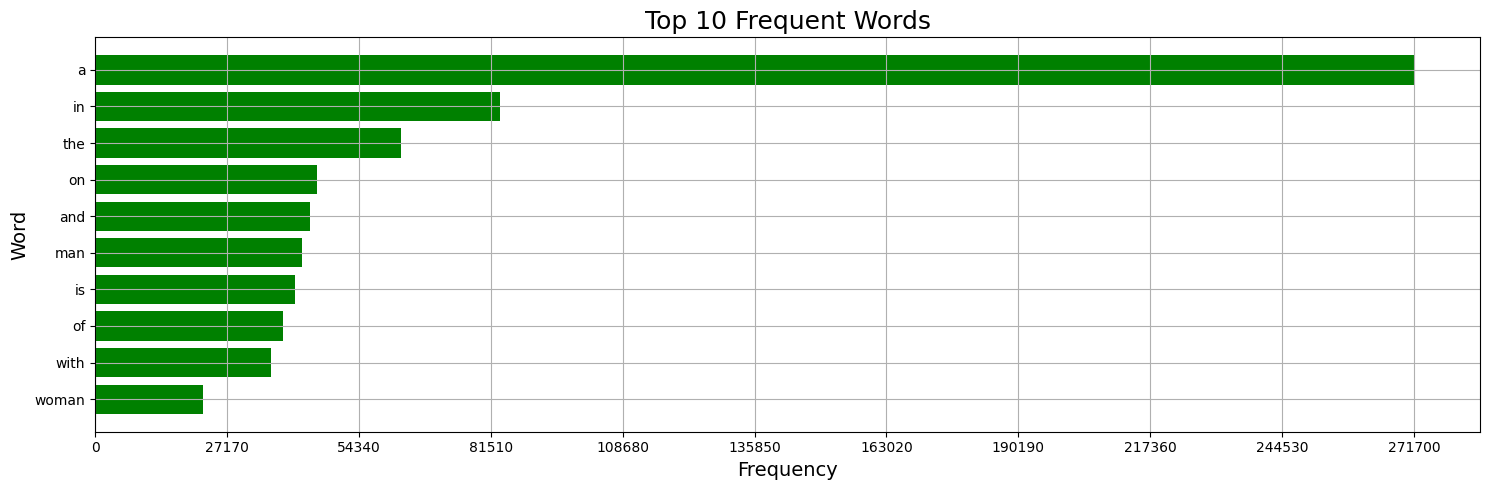

In [10]:
top_frequent = 10
word_counts = Counter()

# Tokenize the captions and count the word frequencies
for caption in im_cap_df['caption']:
    caption = standardize_text(caption)
    caption_tokens = caption.split()  
    word_counts.update(caption_tokens)

# Display the total and unique token counts
print("Total number of tokens:", sum(word_counts.values()))
print("Number of unique tokens:", len(word_counts))

# Get the top frequent words and their frequencies
most_common_words = word_counts.most_common(top_frequent)

# Unzip the words and frequencies
words, frequencies = zip(*most_common_words)

# Create a horizontal bar plot
plt.figure(figsize=(15, 5))
plt.title(f"Top {top_frequent} Frequent Words", fontsize=18)
plt.barh(words, frequencies, color='green')
plt.grid(True)

# Set x-axis ticks and ensure it scales with the frequency
plt.xticks(range(0, max(frequencies) + 1, max(1, (max(frequencies) // 10))))  # Dynamically scale the ticks
plt.gca().invert_yaxis()  # Optional: Display most frequent words at the top

plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word', fontsize=14)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

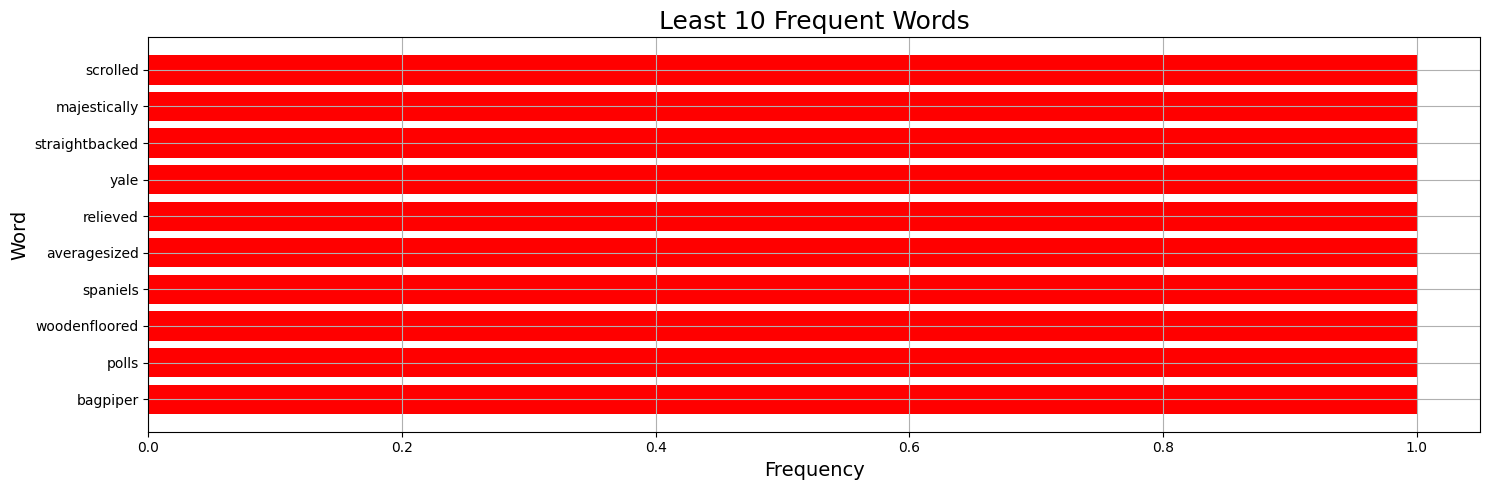

In [11]:
least_frequent = 10

# Ensure that there are enough words to get the least frequent ones
least_common_words = word_counts.most_common()[-least_frequent:] if len(word_counts) >= least_frequent else word_counts.most_common()

# Extract frequencies and words
words, frequencies = zip(*least_common_words)

# Plot the least frequent words
plt.figure(figsize=(15, 5))
plt.title(f"Least {least_frequent} Frequent Words", fontsize=18)
plt.barh(words, frequencies, color='red')  # Color change for distinction
plt.grid(True)

plt.ylabel('Word', fontsize=14)
plt.xlabel('Frequency', fontsize=14)

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [12]:
print("=========== Stats: ===========")
if frequencies:  # Check if the frequencies list is not empty
    print("Minimum Words Frequency:", min(frequencies))
    print("Maximum Words Frequency:", max(frequencies))
    print("Average Frequency:", sum(frequencies) / len(frequencies))
else:
    print("No frequencies available.")


=========== Stats: ===========
Minimum Words Frequency: 1
Maximum Words Frequency: 1
Average Frequency: 1.0


# **The Vocabulary Class**

In [13]:
class Vocabulary:
    ''' 
    This class is used to build a vocabulary from a list of captions, 
    where only words that appear more frequently than the specified threshold are included.
    '''
    
    def __init__(self, caption_list, freq_threshold):
        """
        Initializes the Vocabulary class.
        
        Args:
            caption_list (list of str): A list of captions where each caption is a string.
            freq_threshold (int): The minimum frequency for a word to be included in the vocabulary.
        """
        self.caption_list = caption_list
        self.threshold = freq_threshold
        
        # Adding special tokens
        self.idx2wrd = {0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unknown>'}
        self.wrd2idx = {word: idx for idx, word in self.idx2wrd.items()}
        
        # Build the vocabulary by calling create_vocab() method
        self.create_vocab()
    
    def create_vocab(self):
        """
        Creates the vocabulary by counting word frequencies and including words that
        appear more than the specified frequency threshold.
        """
        # Tokenize all the captions and create a list of all words
        all_tokens = [word for caption in self.caption_list for word in caption.split()]
        
        # Count word frequencies using Counter
        word_counts = Counter(all_tokens)
        
        # Start adding words after the special tokens in the vocabulary
        index = len(self.idx2wrd)  # Start after the special tokens
        
        # Add words to the vocabulary that meet the frequency threshold
        for word, count in word_counts.items():
            if count >= self.threshold and word not in self.wrd2idx:
                self.wrd2idx[word] = index
                self.idx2wrd[index] = word
                index += 1
    
    def cap2tensor(self, caption):
        """
        Converts a caption (string) into a tensor of word indices, adding special tokens 
        at the beginning and end of the caption.
        
        Args:
            caption (str): A caption string to convert into a tensor of word indices.
        
        Returns:
            torch.tensor: A tensor representing the numericalized version of the caption.
        """
        # Initialize the caption with the <start> token ID
        numericalized_caption = [self.wrd2idx['<start>']]
        
        # Convert each word in the caption to its corresponding word ID
        for word in caption.split():
            # If the word exists in the vocabulary, use its ID, else use the <unknown> token ID
            if word in self.wrd2idx:
                numericalized_caption.append(self.wrd2idx[word])
            else:
                numericalized_caption.append(self.wrd2idx['<unknown>'])
        
        # Add the <end> token ID at the end of the caption
        numericalized_caption.append(self.wrd2idx['<end>'])
        
        # Return the numericalized caption as a tensor
        return torch.tensor(numericalized_caption)
    
    def __len__(self):
        """
        Returns the number of words in the vocabulary.
        
        Returns:
            int: The size of the vocabulary (including special tokens).
        """
        return len(self.wrd2idx)


# **Custom dataset class**

In [14]:
class Captioning_dataset(Dataset):
    ''' 
    This class returns preprocessed image and tokenized caption tensors needed by the DataLoader. 
    It loads images, applies transformations, and tokenizes captions using the provided vocabulary.
    '''
    def __init__(self, img_path, im_cap_df, vocab, img_transform=None):
        """
        Initializes the dataset.
        
        Args:
            img_path (str): Path to the image directory.
            im_cap_df (pd.DataFrame): DataFrame containing image names and their corresponding captions.
            vocab (Vocabulary): The vocabulary object used to convert captions to token indices.
            img_transform (callable, optional): A transformation to apply to images (e.g., resizing, normalization).
        """
        self.img_path = img_path
        self.im_cap_df = im_cap_df
        self.captions_list = im_cap_df['caption']
        self.img_names_list = im_cap_df['Image_name']
        self.vocab = vocab
        self.transformation = img_transform

    def __len__(self):
        """
        Returns the total number of samples (images and captions) in the dataset.
        """
        return len(self.im_cap_df)

    def __getitem__(self, item_index):
        """
        Returns the image and tokenized caption pair at the specified index.
        
        Args:
            item_index (int): The index of the image-caption pair to fetch.

        Returns:
            tuple: A tuple containing the image tensor and the tokenized caption tensor.
        """
        image_name = self.img_names_list[item_index]
        caption = self.captions_list[item_index]
        
        # Read the image and convert color channels from BGR (OpenCV default) to RGB
        img = cv2.imread(os.path.join(self.img_path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)  # Convert the NumPy array to a PIL image object

        # Apply transformations (e.g., resizing, normalization) if specified
        if self.transformation is not None:
            img = self.transformation(img)

        # Convert the caption into a tensor of word indices
        caption = self.vocab.cap2tensor(caption)
        
        return img, caption  # Return a tuple: image tensor and numericalized caption tensor

        
class Custom_collate_fn:
    ''' 
    Custom collate function to handle batching. This function pads captions to ensure uniform batch sizes 
    and concatenates image tensors along the batch dimension.
    '''
    def __init__(self, vocab, batch_first=True):
        """
        Initializes the collate function.
        
        Args:
            vocab (Vocabulary): The vocabulary object used for padding captions.
            batch_first (bool): Whether to return the batch with the batch dimension first.
        """
        self.vocab = vocab
        self.batch_first = batch_first

    def __call__(self, batch):
        """
        Processes the batch by padding the captions and stacking the images.
        
        Args:
            batch (list): A list of tuples containing image tensors and caption tensors.
        
        Returns:
            tuple: A tuple containing:
                - A tensor of images with shape (batch_size, Channels, Width, Height)
                - A tensor of captions with shape (batch_size, max_caption_length)
        """
        # Stack all image tensors in the batch along the batch dimension (0)
        images_batch = [item[0].unsqueeze(0) for item in batch]  # Add a batch dimension (1, C, H, W)
        images_batch = torch.cat(images_batch, dim=0)  # Concatenate along the batch dimension (0)
        
        # Pad the captions to have the same length (max_caption_length)
        captions_batch = [item[1] for item in batch]
        captions_batch = pad_sequence(captions_batch, batch_first=self.batch_first, 
                                      padding_value=self.vocab.wrd2idx['<pad>'])  # Pad with <pad> index
        
        return images_batch, captions_batch  # Return a batch of images and padded captions


Loading 31783 batches, each of size: 5
----------------- sample -----------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..2.5877128].


Decoded caption:
 <start> a black dog and a white dog race in a grassy field while spectators look on <end> <pad>
Caption tensor: 
tensor([   1,   31,  100,  221,   87,   31,   20,  221, 1469,   17,   31,  470,
         727,   14, 1171,   10,   52,    2,    0])


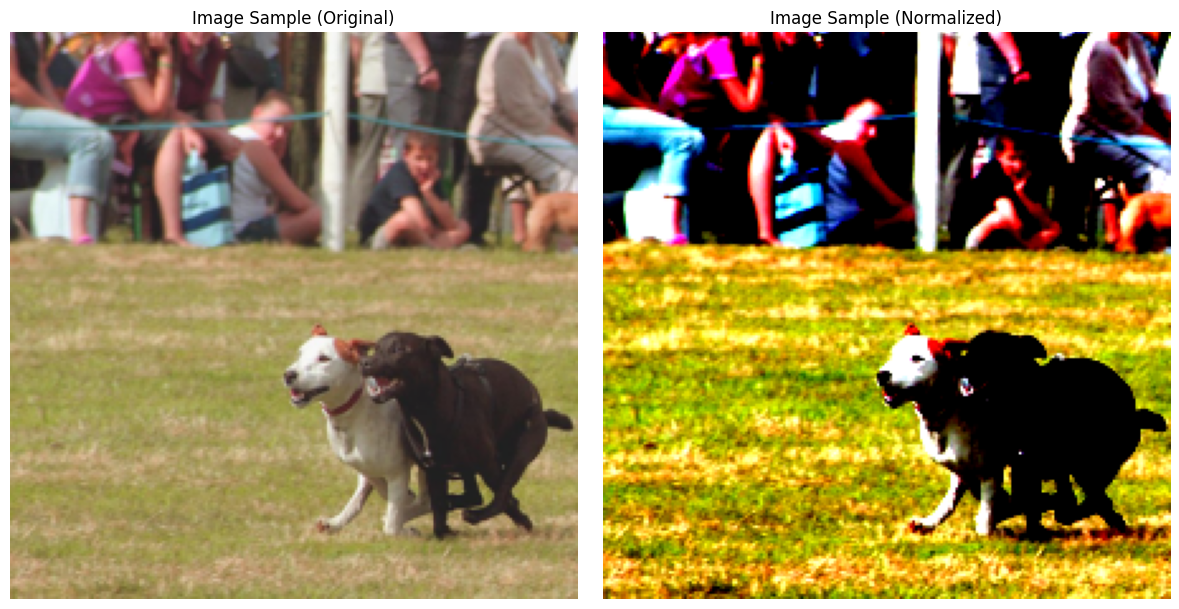

In [15]:
'''Visualizing How the (image,caption) pairs will be passed to the model'''

# Define batch size
batchsize = 5  # Batch size > 1 to visualize padding in action

# Create a vocabulary object with frequency threshold of 10 (words appearing at least 10 times)
voc = Vocabulary(im_cap_df['caption'], 10)

# Create a dataset object with image transformation and vocabulary
dataset = Captioning_dataset(image_path, im_cap_df, voc, image_transformation)

# Create a DataLoader with the dataset and custom collate function to handle batches and padding
train_dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True, collate_fn=Custom_collate_fn(voc))

# Loading batches information
print(f"Loading {len(train_dataloader)} batches, each of size: {batchsize}")
print("----------------- sample -----------------")

# Access the first batch from the DataLoader
batch = next(iter(train_dataloader))
images_tensor, captions_tensor = batch

# Access the first image and its corresponding caption from the batch
first_image = images_tensor[0]
first_caption_tensor = captions_tensor[0]

# Decode the first caption from tensor indices back to text
decoded_caption = " ".join([voc.idx2wrd[idx.item()] for idx in first_caption_tensor])

# Print the decoded caption and its corresponding tensor
print(f"Decoded caption:\n {decoded_caption}")
print(f"Caption tensor: \n{first_caption_tensor}")

# Denormalize the first image for visualization (show original image)
first_image_normalized = detensorize_image(first_image, mean_normalization_vec, std_normalization_vec, denormalize=False)
first_image_denormalized = detensorize_image(first_image, mean_normalization_vec, std_normalization_vec, denormalize=True)

# Visualize both images (original and normalized) side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 grid for side-by-side comparison

# Display the denormalized image
axes[0].imshow(first_image_denormalized)
axes[0].set_title("Image Sample (Original)")
axes[0].axis("off")

# Display the normalized image
axes[1].imshow(first_image_normalized)
axes[1].set_title("Image Sample (Normalized)")
axes[1].axis("off")

# Show the plot
plt.tight_layout()
plt.show()


## **Resnet101 Image Encoder**

In [16]:
class Image_encoder(nn.Module):
    '''
    This class uses a pre-trained ResNet101 model to extract features from images.
    It excludes the last two layers (fully connected layer and classification layer), 
    as these layers are used for classification, and we only need the previous layers 
    to extract image features that will be passed to the attention layer later.
    '''
    def __init__(self):
        super(Image_encoder, self).__init__()

        # Load a pre-trained ResNet101 model
        self.resnet = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
        # Freeze the parameters of the ResNet model so that they are not updated during training
        for param in self.resnet.parameters():
            param.requires_grad_(False)

        # Remove the last two layers (fully connected and classification layer)
        self.layers_list = list(self.resnet.children())[:-2]  # Remove the last two layers
        self.Resnet = nn.Sequential(*self.layers_list)  # Create a new model with the remaining layers

    def forward(self, image_tensor):
        '''
        Forward pass through the model. This method processes the input image tensor 
        and extracts the feature map from ResNet101.
        
        Parameters:
            image_tensor (torch.Tensor): Input tensor of images. Shape: (batch_size, 3, H, W)
        
        Returns:
            torch.Tensor: Flattened feature map of shape (batch_size, 49, 2048).
        '''
        # Pass the image tensor through ResNet101 (excluding the last two layers)
        features = self.Resnet(image_tensor)  # Output shape: (batch_size, 2048, 7, 7)

        # Permute the dimensions of the feature map to (batch_size, 7, 7, 2048)
        features = features.permute(0, 2, 3, 1)  # Shape: (batch_size, 7, 7, 2048)

        # Flatten the feature map to a 2D tensor (batch_size, 49, 2048)
        features = features.view(features.size(0), -1, features.size(-1))  # Flatten the (7x7) feature map
        
        return features  # Shape: (batch_size, 49, 2048)


In [17]:
# summary for the CNN layers included
encoder = Image_encoder()
summary(encoder)

Layer (type:depth-idx)                        Param #
Image_encoder                                 --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│    │    └─Bottleneck: 3-9                   (1,1

## **Attention Layer**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    '''
    This class implements the Bahdanau-style soft Attention mechanism. 
    The attention mechanism computes a context vector for each word in the caption 
    by attending to specific parts of the image, which depends on the hidden state 
    of the previous time step. This helps the model to focus on relevant image regions 
    when generating the next word in the sequence.
    '''
    def __init__(self, features_dims, hidden_state_dims, attention_dims):
        '''
        Initialize the attention layer with the given dimensions.

        Parameters:
        - features_dims: The dimensionality of the image features (e.g., 2048 from ResNet).
        - hidden_state_dims: The dimensionality of the hidden state of the RNN.
        - attention_dims: The size of the attention space.
        '''
        super().__init__()

        # Attention weights for the image features
        self.U = nn.Linear(features_dims, attention_dims)
        
        # Attention weights for the hidden state
        self.W = nn.Linear(hidden_state_dims, attention_dims)
        
        # Linear layer to calculate attention scores from combined states
        self.A = nn.Linear(attention_dims, 1)

    def forward(self, img_features, hidden_state):
        '''
        Forward pass for the Attention layer.

        Parameters:
        - img_features (torch.Tensor): The image features from the image encoder, shape (batch_size, num_pixels, features_dims).
        - hidden_state (torch.Tensor): The hidden state of the RNN, shape (batch_size, hidden_state_dims).

        Returns:
        - alpha (torch.Tensor): The attention weights (alpha) for each image feature, shape (batch_size, num_pixels).
        - context_vector (torch.Tensor): The weighted sum of image features, shape (batch_size, features_dims).
        '''
        
        # Apply the linear layer to image features to obtain U(x)
        u_hs = self.U(img_features)  # Shape: (batch_size, num_pixels, attention_dims)
        
        # Apply the linear layer to the hidden state to obtain W(h_t-1)
        w_hs = self.W(hidden_state)  # Shape: (batch_size, attention_dims)

        # Combine the image features and hidden state, then apply tanh activation
        combined_states = torch.tanh(u_hs + w_hs.unsqueeze(1))  # Shape: (batch_size, num_pixels, attention_dims)
        
        # Calculate attention scores for each pixel (image feature)
        attention_scores = self.A(combined_states)  # Shape: (batch_size, num_pixels, 1)

        # Squeeze the attention scores to remove the last dimension (making it a vector)
        attention_scores = attention_scores.squeeze(2)  # Shape: (batch_size, num_pixels)

        # Apply softmax to normalize the attention scores (convert to probabilities)
        alpha = F.softmax(attention_scores, dim=1)  # Shape: (batch_size, num_pixels)

        # Calculate the context vector by taking the weighted sum of image features
        context_vector = img_features * alpha.unsqueeze(2)  # Shape: (batch_size, num_pixels, features_dims)
        
        # Sum the weighted image features across all pixels to obtain the final context vector
        context_vector = context_vector.sum(dim=1)  # Shape: (batch_size, features_dims)

        # Return both alpha (attention weights) for visualization and context_vector for feeding to the RNN
        return alpha, context_vector


## **The LSTM decoder**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention_Based_Decoder(nn.Module):
    '''
    This class implements an LSTM-based decoder for image captioning with an attention mechanism. 
    The decoder uses both the current token and the context vector (generated by the AttentionLayer) 
    to predict the next token in the sequence. 
    At timestep 0, the initial hidden state is initialized using the normalized image's feature vector.
    '''
    def __init__(self, features_dims, hidden_state_dims, attention_dims, word_emb_dims, vocab_size, drop_prob):
        '''
        Initialize the attention-based decoder with the provided parameters.

        Parameters:
        - features_dims: The dimensionality of the image features (e.g., 2048).
        - hidden_state_dims: The dimensionality of the hidden state of the LSTM.
        - attention_dims: The size of the attention space.
        - word_emb_dims: The dimensionality of the word embeddings.
        - vocab_size: The size of the vocabulary (number of unique tokens).
        - drop_prob: The dropout probability for regularization.
        '''
        super(Attention_Based_Decoder, self).__init__()

        self.vocab_size = vocab_size

        # Dropout layer for regularization
        self.dropout_layer = nn.Dropout(drop_prob)

        # Attention mechanism to focus on relevant parts of the image
        self.attention_layer = AttentionLayer(features_dims, hidden_state_dims, attention_dims)

        # Token embedding layer
        self.tokens_embedding = nn.Embedding(vocab_size, word_emb_dims)

        # Fully connected layers to initialize the hidden and cell states
        self.hidden_state_init = nn.Linear(features_dims, hidden_state_dims)
        self.cell_state_init = nn.Linear(features_dims, hidden_state_dims)

        # LSTM cell for decoding the sequence
        self.lstm_cell = nn.LSTMCell(word_emb_dims + features_dims, hidden_state_dims, bias=True)

        # Fully connected layer to map hidden state to vocabulary size for prediction
        self.fcl = nn.Linear(hidden_state_dims, vocab_size)

    def init_hidden_state(self, image_features_tensor):
        '''
        Initialize the hidden and cell states of the LSTM using the image features.

        Parameters:
        - image_features_tensor (torch.Tensor): The image features, shape (batch_size, num_pixels, features_dims).

        Returns:
        - h (torch.Tensor): The initial hidden state, shape (batch_size, hidden_state_dims).
        - c (torch.Tensor): The initial cell state, shape (batch_size, hidden_state_dims).
        '''
        # Mean of the image features along the pixel dimension
        features_mean = image_features_tensor.mean(dim=1)

        # Initialize hidden and cell states using fully connected layers
        h = self.hidden_state_init(features_mean)
        c = self.cell_state_init(features_mean)

        return h, c

    def forward(self, batch_images_features, batch_captions_tensors):
        '''
        Forward pass for the attention-based decoder.

        Parameters:
        - batch_images_features (torch.Tensor): The image features for the batch, shape (batch_size, num_pixels, features_dims).
        - batch_captions_tensors (torch.Tensor): The tokenized captions, shape (batch_size, max_caption_length).

        Returns:
        - preds (torch.Tensor): The predicted token probabilities for each timestep, shape (batch_size, max_caption_length, vocab_size).
        - alphas (torch.Tensor): The attention weights (alpha) for each token, shape (batch_size, max_caption_length, num_pixels).
        '''
        captions_len = len(batch_captions_tensors[0]) - 1  # Caption length minus 1 (excluding <end> token)
        batch_size = batch_captions_tensors.size(0)          # Number of captions in the batch

        features_size = batch_images_features.size(1)       # Size of the image feature vector (e.g., 49 pixels)

        # Embedding of the caption tokens
        embedded_tokens = self.tokens_embedding(batch_captions_tensors)

        # Initialize hidden and cell states
        hidden_state, cell_state = self.init_hidden_state(batch_images_features)

        # Initialize output tensors
        preds = torch.zeros(batch_size, captions_len, self.vocab_size).to(device)  # Predicted probabilities for each token
        alphas = torch.zeros(batch_size, captions_len, features_size).to(device)    # Attention weights for each token
        
        for wrd_index in range(captions_len):
            # Apply attention mechanism
            alpha, context_vector = self.attention_layer(batch_images_features, hidden_state)
            
            # Get the embedding for the current word in the caption (using teacher forcing)
            current_token_emb = embedded_tokens[:, wrd_index]

            # Concatenate current token embedding and context vector
            lstm_input = torch.cat((current_token_emb, context_vector), dim=1)

            # Get the next hidden state and cell state from the LSTM cell
            hidden_state, cell_state = self.lstm_cell(lstm_input, (hidden_state, cell_state))

            # Compute the token probabilities for the next word in the sequence
            tokens_probs = self.fcl(self.dropout_layer(hidden_state))

            # Store the predicted probabilities and attention weights
            preds[:, wrd_index] = tokens_probs
            alphas[:, wrd_index] = alpha

        return preds, alphas


**The Encoder-Decoder Model**(putting everything together)

In [20]:
class Encoder_Decoder_Model(nn.Module):
    '''
    The final captioning model consists of three main components:*

    The Encoder: Extracts image features and passes them to the attention layer.
    Attention Layer: Combines extracted image features with the hidden state generated by the RNN (LSTM) in the previous timestep to create a context vector.
    LSTM Component: Uses the context vector generated by the attention mechanism, along with the previous hidden state, to predict the next token in the sequence.
    '''
    def __init__(self, features_dims, hidden_state_dims, attention_dims, word_emb_dims, vocab_size, drop_prob):
        '''
        Initializes the Encoder-Decoder model with the provided parameters.

        Parameters:
        - features_dims: Dimensionality of the image feature vector.
        - hidden_state_dims: Dimensionality of the LSTM hidden state.
        - attention_dims: Dimensionality of the attention space.
        - word_emb_dims: Dimensionality of the word embeddings.
        - vocab_size: The number of unique words in the vocabulary.
        - drop_prob: Dropout probability for regularization.
        '''
        super(Encoder_Decoder_Model, self).__init__()

        # Initialize the image encoder and attention-based decoder
        self.img_encoder = Image_encoder()  # Encodes image features
        self.decoder = Attention_Based_Decoder(features_dims, hidden_state_dims, attention_dims, word_emb_dims, vocab_size, drop_prob)

    def forward(self, batch_images, batch_tokenized_captions):
        '''
        Forward pass for the Encoder-Decoder model.

        Parameters:
        - batch_images (torch.Tensor): The batch of images, shape (batch_size, channels, height, width).
        - batch_tokenized_captions (torch.Tensor): The batch of tokenized captions, shape (batch_size, max_caption_length).

        Returns:
        - probs (torch.Tensor): The predicted probabilities for each token in the caption, shape (batch_size, max_caption_length, vocab_size).
        - alphas (torch.Tensor): The attention weights (alpha) for each token, shape (batch_size, max_caption_length, num_pixels).
        '''
        # Encode the images using the ImageEncoder
        image_features = self.img_encoder(batch_images)

        # Generate the predictions and attention weights using the decoder
        probs, alphas = self.decoder(image_features, batch_tokenized_captions)

        return probs, alphas

    def predict(self, image, vocab, max_cap_len=20, debugging=False):
        '''
        Predicts a caption for a given image.

        Parameters:
        - image (np.array): The input image to caption (in BGR format).
        - vocab (Vocabulary): The vocabulary object containing mappings for words.
        - max_cap_len (int): The maximum length of the generated caption.
        - debugging (bool): If True, prints debugging information.

        Returns:
        - attentions (list): A list of attention weights (alpha) for each token in the caption.
        - caption (list): The generated caption (list of words).
        '''
        self.eval()  # Set the model to evaluation mode
        
        with torch.no_grad():
            # Preprocess the input image
            img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            img = image_transformation(img).unsqueeze(0).to(device)  # Apply transformations and move to device

            # Extract image features using the encoder
            image_features = self.img_encoder(img)

            if debugging:
                print(f"Predict input image shape: {image_features.shape}")  # Debugging information

            # Initialize the hidden and cell states of the decoder
            hidden_state, cell_state = self.decoder.init_hidden_state(image_features)

            # Start with the <start> token in the caption
            caption = [vocab.idx2wrd[1]]  # Start with <start> token
            token = torch.tensor(vocab.wrd2idx["<start>"]).unsqueeze(0).to(device)

            attentions = []  # To store attention weights

            for i in range(max_cap_len):
                # Apply the attention mechanism to get the context vector
                alpha, context_vector = self.decoder.attention_layer(image_features, hidden_state)

                if debugging:
                    print(f"Step {i} - Attention map for token: {vocab.idx2wrd[token.item()]} is {alpha.shape}")

                attentions.append(alpha.cpu().detach().numpy())  # Store attention weights for debugging

                # Get the embedding for the current token
                current_token_emb = self.decoder.tokens_embedding(token)

                # Concatenate the current token embedding with the context vector
                lstm_input = torch.cat((current_token_emb.squeeze(1), context_vector), dim=1)

                # Get the next hidden and cell states from the LSTM
                hidden_state, cell_state = self.decoder.lstm_cell(lstm_input, (hidden_state, cell_state))

                # Compute the token probabilities
                tokens_prob = self.decoder.fcl(hidden_state)

                # Get the predicted next token (word)
                next_token = tokens_prob.argmax(dim=1).item()
                next_word = vocab.idx2wrd[next_token]

                caption.append(next_word)  # Append the predicted word to the caption

                # If the <end> token is predicted, stop the generation
                if next_word == "<end>":
                    break

                # Use the predicted token as the input for the next timestep
                token = torch.tensor([next_token]).unsqueeze(0).to(device)

            if debugging:
                print(f"Attention shape: {np.array(attentions).shape}")
                print(f"Caption length: {len(caption)}")

            return attentions, caption  # Return the attention weights and the generated caption


# **Training**

In [21]:
# Set the device (CUDA or CPU)
device = set_cuda()

# Define hyperparameters
LEARNING_RATE = 1e-4

WORD_EMB_SIZE = 400
ATTENTION_DIMS = 512  # 2048 pixels/512 attention vector = 16 ---> Each attention score attends to 8 pixels in the feature map
HIDDEN_STATE_DIMS = 1024

NUM_EPOCHS = 2 # 10
BATCH_SIZE = 64 # 128

# Set up the vocabulary
vocab = Vocabulary(im_cap_df['caption'], 5)  # Set min threshold to 5 occurrences
VOCAB_SIZE = len(vocab)

# Initialize the model
model = Encoder_Decoder_Model(
    features_dims=2048,
    hidden_state_dims=HIDDEN_STATE_DIMS,
    attention_dims=ATTENTION_DIMS,
    word_emb_dims=WORD_EMB_SIZE,
    vocab_size=VOCAB_SIZE,
    drop_prob=0.5
)

Device in use: cpu


In [22]:
"""
This code splits the dataset into training and validation sets based on unique image names to ensure no data leakage.

- **Data Splitting**:
    - The `random_split` function is used on the unique image names to divide the dataset into a training set (90%) and a validation set (10%).
    - This prevents the same image from appearing in both sets, which could cause data leakage since each image has multiple captions.

- **DataFrames**:
    - The original `im_cap_df` dataframe is filtered to create `train_df` and `val_df`, containing only the images that belong to the training and validation sets, respectively.

- **Dataset Creation**:
    - `train_dataset` and `val_dataset` are created using the filtered dataframes, which are passed to the `Captioning_dataset` class along with the image transformations and vocabulary.

- **DataLoader Creation**:
    - The `train_dataloader` and `val_dataloader` are created using the `DataLoader` class, specifying batch size, number of workers, memory pinning, and the custom collate function.
    - These DataLoaders are responsible for providing batches of preprocessed images and tokenized captions for training and evaluation.

This ensures that the model is trained and validated on separate sets of images, avoiding overlap and potential data leakage.
"""

# Extract unique image names to ensure no overlap between training and validation datasets
unique_imgs_names = list(im_cap_df['Image_name'].unique())

# Split the unique image names into train and validation sets (90% for training, 10% for validation)
train_imgs, val_imgs = torch.utils.data.random_split(unique_imgs_names, [0.9, 0.1])

# Convert the indices to actual image names
train_imgs = [unique_imgs_names[idx] for idx in train_imgs.indices]
val_imgs = [unique_imgs_names[idx] for idx in val_imgs.indices]

# Create training and validation dataframes based on the image names
train_df = im_cap_df[im_cap_df['Image_name'].isin(train_imgs)].reset_index(drop=True)
val_df = im_cap_df[im_cap_df['Image_name'].isin(val_imgs)].reset_index(drop=True)

# Create the datasets for training and validation
train_dataset = Captioning_dataset(image_path, train_df, vocab, image_transformation)
val_dataset = Captioning_dataset(image_path, val_df, vocab, image_transformation)

# Create the DataLoader instances for both training and validation datasets
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    collate_fn=Custom_collate_fn(vocab)
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
    collate_fn=Custom_collate_fn(vocab)
)

Training Loop

In [23]:
model = model.to(device)

CRITERION = nn.CrossEntropyLoss(ignore_index=dataset.vocab.wrd2idx["<pad>"]).to(device)  # Ignore loss for padding tokens
OPTIMIZER = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print_every = 500  # batches progress are displayed according to this number

training_losses = []
validation_losses = []
best_loss = float('inf')  # Initialize best loss to +infinity

for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="Epochs"):
    print(f"Epoch: {epoch}/{NUM_EPOCHS}")
    train_losses_sum = 0
    model.train()

    for batch, (images_batch, captions_batch) in enumerate(train_dataloader, start=1):
        
        images_batch, captions_batch = images_batch.to(device), captions_batch.to(device)  # move batches to the GPU
        
        OPTIMIZER.zero_grad()
        
        output, _ = model(images_batch, captions_batch)  # forward pass
        ground_truth = captions_batch[:, 1:]  # exclude <start> tag as it won't be predicted by the model
        
        loss = CRITERION(output.view(-1, VOCAB_SIZE), ground_truth.reshape(-1))
        
        loss.backward()
        OPTIMIZER.step()
        
        train_losses_sum += loss.item()

        if loss < best_loss:  # save model if loss improved
            best_loss = loss
            print(f"Model loss improved to: {loss.item()}, saving...")
            torch.save(model.state_dict(), "trained_captioning_model.pt")
        
        if batch % print_every == 0:
            print(f"Batch: {batch}/{len(train_dataloader)}")  # print batch number every (print_every)th batch

    train_avg_loss = train_losses_sum / len(train_dataloader)  # avg loss within the epoch
    training_losses.append(train_avg_loss)  # for plotting losses later
    print(f" Validating....")
    model.eval()
    
    val_losses_sum = 0
    with torch.no_grad():
        for images_batch, captions_batch in val_dataloader:
            images_batch, captions_batch = images_batch.to(device), captions_batch.to(device)
            output, _ = model(images_batch, captions_batch)
            
            ground_truth = captions_batch[:, 1:]
            val_loss = CRITERION(output.view(-1, VOCAB_SIZE), ground_truth.reshape(-1))
            
            val_losses_sum += val_loss.item()
    
    val_avg_loss = val_losses_sum / len(val_dataloader)
    validation_losses.append(val_avg_loss)
    print(f"Epoch {epoch} Average Training loss: {train_avg_loss} - Average Validation loss: {val_avg_loss}")

Epochs:   0%|                                                                                                                                   | 0/2 [00:00<?, ?it/s]

Epoch: 1/2
Model loss improved to: 8.960321426391602, saving...
Model loss improved to: 8.897294044494629, saving...
Model loss improved to: 8.840604782104492, saving...
Model loss improved to: 8.76565170288086, saving...
Model loss improved to: 8.647895812988281, saving...
Model loss improved to: 8.546209335327148, saving...
Model loss improved to: 8.445974349975586, saving...
Model loss improved to: 8.255228996276855, saving...
Model loss improved to: 8.187478065490723, saving...
Model loss improved to: 7.932810306549072, saving...
Model loss improved to: 7.828213214874268, saving...
Model loss improved to: 7.521633148193359, saving...
Model loss improved to: 7.352809906005859, saving...
Model loss improved to: 7.184798717498779, saving...
Model loss improved to: 7.173349857330322, saving...
Model loss improved to: 7.056346893310547, saving...
Model loss improved to: 7.041538238525391, saving...
Model loss improved to: 6.740736484527588, saving...
Model loss improved to: 6.6557111740

Epochs:   0%|                                                                                                                                   | 0/2 [17:04<?, ?it/s]


KeyboardInterrupt: 

## **Plotting Training & Validation Losses**

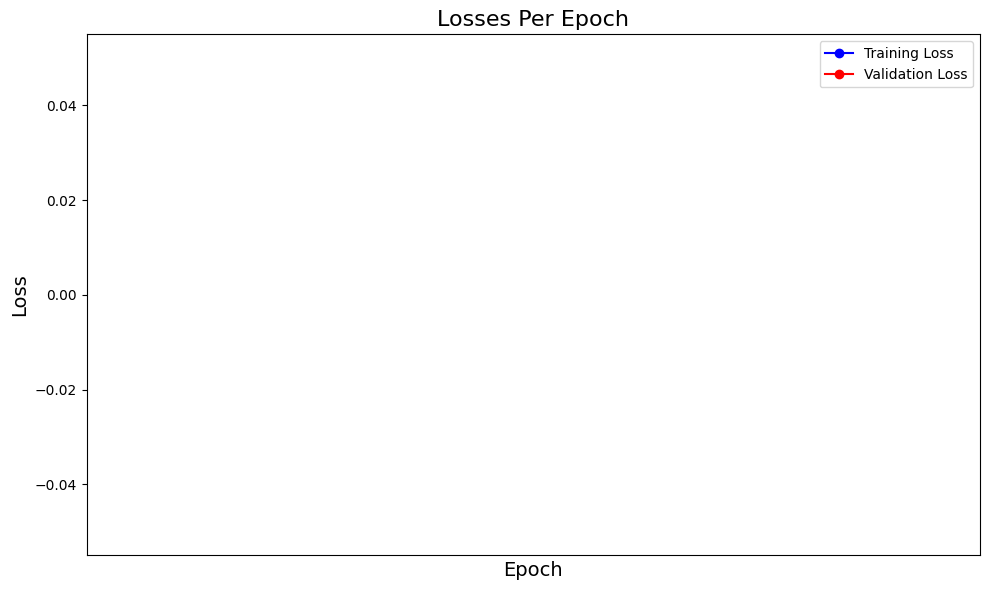

In [24]:
plt.figure(figsize=(10, 6))

# Training loss curve
plt.plot(range(1, len(training_losses) + 1), training_losses, marker='o', color='b', label='Training Loss')

# Validation loss curve
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', color='r', label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Losses Per Epoch', fontsize=16)
plt.legend() # Add legend
plt.xticks(range(1, len(training_losses) + 1)) # Set x-axis ticks
plt.tight_layout() # Layout adjustment
plt.show() # Show plot

## **Saving the model weights and vocab**

In [ ]:
torch.save(model, "model.pt") # Save model (recommended approach)
torch.save(vocab, "vocab.pth") # Save vocabulary (you can save it as a .pth file or .pkl if needed)

# **Inference and Visualizing attentions**

testing on random images uploaded by me...

In [ ]:
# Take image path input from user
image_path = input("Enter image path: ")

# Check if the image exists
if os.path.exists(image_path):
    # Load and process the image
    test_image = cv2.imread(image_path)
    display_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Generate caption and attention scores
    alphas, caption = model.predict(test_image, vocab=vocab, debugging=True)

    # Display the image and caption
    plt.imshow(display_image)
    plt.axis('off')  # Hide axes
    plt.title(" ".join(caption))
    plt.show()

    # Plot attention regions with words
    plot_attention(display_image, caption, alphas)  # Show attention regions
    print("Alphas length:", len(alphas))
    print("Caption length:", len(caption))

else:
    print("Invalid image path.")